### Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from LDA import LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import seaborn as sns


# KNN

### Import the data

In [48]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [49]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]

### Scale the data

In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### LDA

In [51]:
#our LDA
clf = LDA(n_components=4)
clf.fit(X_train, y_train)
lda_transformed_X_train= clf.transform(X_train)
lda_transformed_X_test = clf.transform(X_test)

print(X_test.shape, lda_transformed_X_train.shape)

(5000, 784) (10000, 4)


In [52]:
# Transform to pandas data frame
d = {'LDA1': lda_transformed_X_train[:,0], 'LDA2': lda_transformed_X_train[:,2], 'LDA3': lda_transformed_X_train[:,2], 'LDA4': lda_transformed_X_train[:,3]}
lda_transformed_X_train = pd.DataFrame(d)

In [53]:
# Transform to pandas data frame
d = {'LDA1': lda_transformed_X_test[:,0], 'LDA2': lda_transformed_X_test[:,2], 'LDA3': lda_transformed_X_test[:,2], 'LDA4': lda_transformed_X_test[:,3]}
lda_transformed_X_test = pd.DataFrame(d)

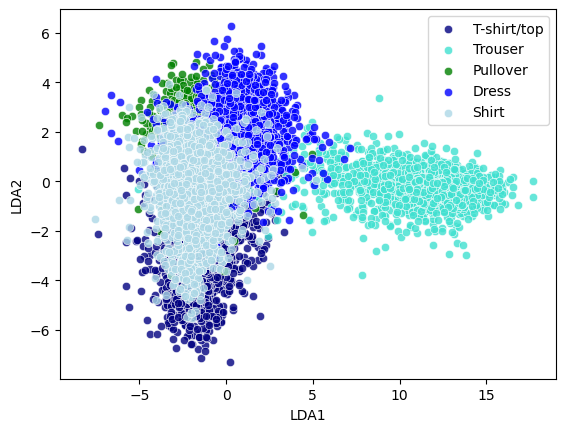

In [54]:
fig, ax = plt.subplots()

colors = colors = ["navy", "turquoise", "green", 'blue', 'lightblue']
components = ['LDA1', 'LDA2', 'LDA3', 'LDA4']
class_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}

for k, c in enumerate(colors):
    sns.scatterplot(data=lda_transformed_X_train[y_train== k], x='LDA1', y='LDA2', alpha=0.8, color=c, label=class_dict[k], ax=ax)

plt.savefig('lda_sklearn_plot.png')

### PCA 

In [91]:
#how many number of principal components needed to retain  of the variance

percentages = [0.91, 0.92, 0.93, 0.94, 0.95, 0.96]
components = {}
for percentage in percentages:
    pca = PCA(percentage).fit(X_train)
    components[percentage] = pca.n_components_

print(components)

{0.91: 71, 0.92: 83, 0.93: 97, 0.94: 114, 0.95: 137, 0.96: 167}


### Cross validation

In [59]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate

In [60]:
#our LDA using 4 components
clf = LDA(n_components=4)
clf.fit(X_train, y_train)
lda_transformed_X_train= clf.transform(X_train)
lda_transformed_X_test = clf.transform(X_test)

print(X_test.shape, lda_transformed_X_train.shape)

(5000, 784) (10000, 4)


In [61]:
n_values = [1,3,5,7,9,1,13,15]

In [62]:
pca_model = make_pipeline(PCA(n_components=137), KNeighborsClassifier(n_neighbors=11) )
cv_result = cross_validate(pca_model, X_train,y_train , cv=5)
cv_result

{'fit_time': array([0.64040399, 0.65002012, 0.59303784, 0.60789299, 0.56251979]),
 'score_time': array([0.23279214, 0.19572401, 0.18947816, 0.22318268, 0.19495225]),
 'test_score': array([0.828 , 0.8375, 0.839 , 0.837 , 0.84  ])}

In [63]:
lda_model = make_pipeline(LinearDiscriminantAnalysis(n_components=4), KNeighborsClassifier(n_neighbors=23) )
cv_result = cross_validate(lda_model, X_train,y_train , cv=5)
cv_result

{'fit_time': array([1.90370679, 1.73763418, 1.74134207, 1.76741719, 1.7379992 ]),
 'score_time': array([0.12021303, 0.1058929 , 0.10184383, 0.1126771 , 0.10319686]),
 'test_score': array([0.8235, 0.818 , 0.8175, 0.8135, 0.814 ])}

In [64]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=23) )
cv_result = cross_validate(model, X_train,y_train , cv=5)
cv_result

{'fit_time': array([0.07127333, 0.07113695, 0.06182194, 0.05914497, 0.06332183]),
 'score_time': array([0.63813305, 0.64355803, 0.64047503, 0.66757703, 0.64076018]),
 'test_score': array([0.8305, 0.8225, 0.82  , 0.824 , 0.822 ])}

In [76]:
n_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 21, 25, 27]
cv = 5

def cross_val_plot(X, y, n_values, cv, method):
    """ plot the different cross-validation scores from each split for different transformed datasets
    input:
    X: Training data features (numpy array or pandas DataFrame)
    y: Training data labels (numpy array or pandas Series)
    n(list): number of neighbors
    cv (int): number of splits
    method: 'lda', 'pca', 'standard', or None
    
    output: accuracy score for each split
    """
    all_results = []

    for n in n_values:
        if method == 'lda':
            model = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis(n_components=4), KNeighborsClassifier(n_neighbors=n))
        elif method == 'pca':
            model = make_pipeline(StandardScaler(),PCA(n_components=83), KNeighborsClassifier(n_neighbors=n))
        elif method == 'standard':
            model = make_pipeline( StandardScaler(),KNeighborsClassifier(n_neighbors=n))
        else:
            model = KNeighborsClassifier(n_neighbors=n)

        cv_result = cross_validate(model, X, y, cv=cv)
        all_results.append(cv_result['test_score'])

    return all_results




In [66]:
standard_cv_plot = cross_val_plot(X_train, y_train, n_values, cv, 'standard')
pca_cv_plot = cross_val_plot(X_train, y_train, n_values, cv, 'pca')
lda_cv_plot = cross_val_plot(X_train, y_train, n_values, cv, 'lda')

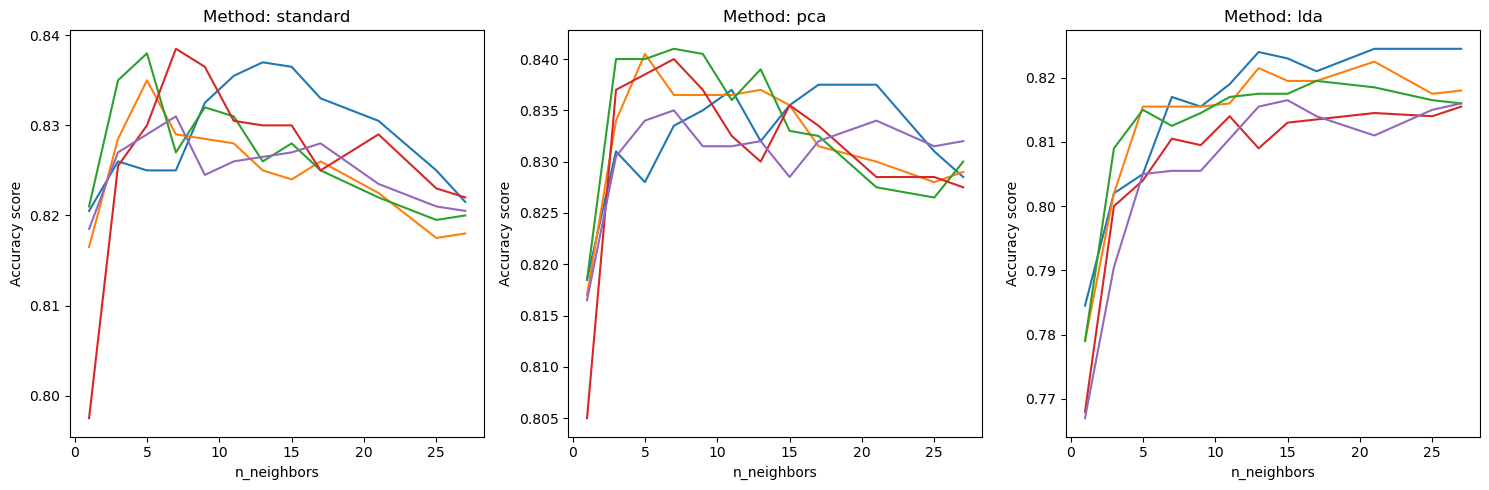

In [67]:
data_set =[standard_cv_plot,pca_cv_plot,lda_cv_plot]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

Methods =['standard','pca','lda']
for i in range(len(data_set)):
    axes[i].plot(n_values, data_set[i], marker='none')
    axes[i].set_title(f'Method: {Methods[i]}')
    axes[i].set_xlabel('n_neighbors')
    axes[i].set_ylabel('Accuracy score')

# plot
plt.savefig("cross_val.png")
plt.tight_layout()
plt.show()

In [77]:
def cross_val_mean(X, y, n, cv, method):
    """
    Calculates the mean score from each split at the same number of neighbours in the cross-validation.

    input:
    X: Training data features (numpy array or pandas DataFrame)
    y: Training data labels (numpy array or pandas Series)
    n_values (list): List of number of neighbors to be tested
    cv (int): Number of splits
    method (str): 'lda', 'pca', 'standard', or 'default'

    output: mean accuracy score for the different splits
    """

    if method == 'lda':
        model = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis(n_components=4), KNeighborsClassifier(n_neighbors=n))
    elif method == 'pca':
        model = make_pipeline(StandardScaler(),PCA(n_components=83), KNeighborsClassifier(n_neighbors=n))
    elif method == 'standard':
        model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=n))
    else:
        model = KNeighborsClassifier(n_neighbors=n)

    cv_result = cross_validate(model, X, y, cv=cv)
    cv_result = cv_result['test_score']

    return np.mean(cv_result)  # Return the mean score



In [78]:
n_values=[1,3,5,7,9,11,13,15,17,21,25]

In [80]:
pca_all_scores = [cross_val_mean(X_train, y_train, n, cv, 'pca') for n in n_values]
lda_all_scores = [cross_val_mean(X_train, y_train, n, cv, 'lda') for n in n_values]
standard_all_scores = [cross_val_mean(X_train, y_train, n, cv, 'standard') for n in n_values]


In [81]:
data_set_all_scores =[pca_all_scores,lda_all_scores, standard_all_scores]

cross validating for diferent number of n neighbours on the different datasets

In [82]:
#seting number of neighbours and number of splits in the cross validation
n_values = [1, 3, 5, 7, 11, 13, 15, 17, 19, 21, 23]
cv = 5

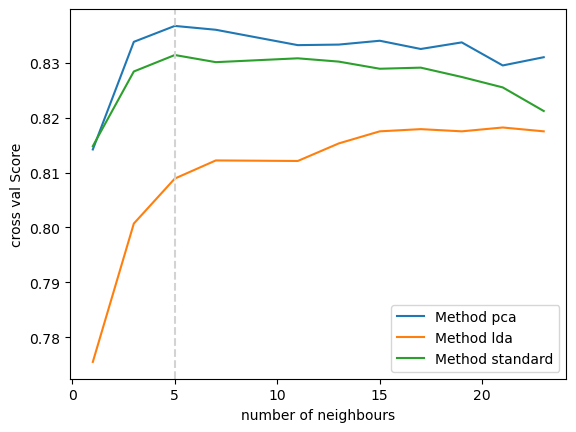

In [85]:
# Create a figure and axis
fig, ax = plt.subplots()

Methods =['pca','lda','standard']
# Plot each set of scores
for i, scores in enumerate(data_set_all_scores):
    label = f'Method {Methods[i]}'  # You can customize the labels
    ax.plot(n_values,scores, label=label)

# Add labels and legend
ax.set_xlabel('number of neighbours')
ax.set_ylabel('cross val Score')
ax.legend()
ax.axvline(x=5, color='lightgrey', linestyle='--', label='x=5')
# Show the plot
plt.savefig("cross_val_knn_lda_pca.png")
plt.show()


investigating LDA further

In [74]:
def cross_val_mean_lda(X, y,n_comp, n, cv, method):
    """
    Calculates the mean score from each split in the cross-validation.

    input:
    X:
    y:
    n_values (list): List of number of neighbors to be tested
    cv (int): Number of splits
    method (str): 'lda', 'pca', 'standard', or 'default'

    output: mean score from each split
    """

    if method == 'lda':
        model = make_pipeline(StandardScaler(),LinearDiscriminantAnalysis(n_components=n_comp), KNeighborsClassifier(n_neighbors=n))
    elif method == 'pca':
        model = make_pipeline(StandardScaler(),PCA(n_components=n_comp), KNeighborsClassifier(n_neighbors=n))
    
    cv_result = cross_validate(model, X, y, cv=cv)
    cv_result = cv_result['test_score']

    return np.mean(cv_result)  # Return the mean score



In [ ]:
lda_1 = [cross_val_mean_lda(X_train, y_train,1, n, cv, 'lda') for n in n_values]
lda_2 = [cross_val_mean_lda(X_train, y_train,2, n, cv,'lda') for n in n_values]
lda_3 = [cross_val_mean_lda(X_train, y_train,3, n, cv, 'lda') for n in n_values]
lda_4= [cross_val_mean_lda(X_train, y_train,4, n, cv,'lda') for n in n_values]


In [ ]:
pca_1 = [cross_val_mean_lda(X_train_std, y_train,62, n, cv, 'pca') for n in n_values]#90%
pca_2 = [cross_val_mean_lda(X_train_std, y_train,83, n, cv, 'pca') for n in n_values]#92%
pca_3 = [cross_val_mean_lda(X_train_std, y_train,97, n, cv, 'pca') for n in n_values] #93%
pca_4 = [cross_val_mean_lda(X_train_std, y_train,114, n, cv,'pca') for n in n_values] #94%
pca_5 = [cross_val_mean_lda(X_train_std, y_train,137, n, cv, 'pca') for n in n_values]#95%
pca_6= [cross_val_mean_lda(X_train_std, y_train,210, n, cv,'pca') for n in n_values]


In [ ]:
data_sets_pca = [pca_1,pca_2,pca_3,pca_4, pca_5,pca_6]

In [ ]:
data_set_lda =[lda_1,lda_2,lda_3,lda_4]

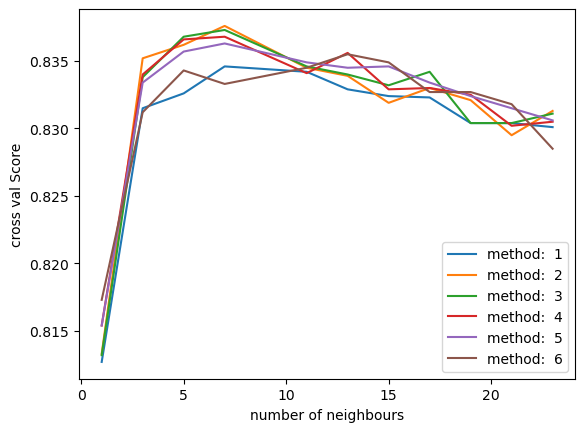

In [ ]:
fig, ax = plt.subplots()

def plot_diff_components(data,n_values):

    # Plot each set of scores
    for i, scores in enumerate(data):
        label = f'method:  {i+1}' 
        ax.plot(n_values,scores, label=label)


    ax.set_xlabel('number of neighbours')
    ax.set_ylabel('cross val Score')
    ax.legend()
    plt.savefig("pca_diff_components.png")
    plt.show()

plot_diff_components(data_sets_pca, n_values)

### Train final classifier

LDA

In [97]:
# Train and apply LDA
lda = LDA(n_components=4)
lda.fit(X_train, y_train)
lda_transformed_X_train = lda.transform(X_train_std)
lda_transformed_X_test = lda.transform(X_test_std)

In [98]:
# KNN
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(lda_transformed_X_train, y_train)

KNeighborsClassifier(n_neighbors=21)

In [99]:
lda_yhat = knn.predict(lda_transformed_X_test)
lda_yhat_proba = knn.predict_proba(lda_transformed_X_test)

PCA

In [100]:
pca = PCA(n_components=83)
pca.fit(X_train, y_train)
pca_transformed_X_train = pca.transform(X_train_std)
pca_transformed_X_test = pca.transform(X_test_std)

In [101]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(pca_transformed_X_train, y_train)

KNeighborsClassifier()

In [102]:
pca_yhat = knn.predict(pca_transformed_X_test)
pca_yhat_proba = knn.predict_proba(pca_transformed_X_test)

only knn

In [103]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)

KNeighborsClassifier()

In [104]:
yhat = knn.predict(X_test_std)
yhat_proba = knn.predict_proba(X_test_std)

### Test

In [108]:
accuracy_score(y_test, pca_yhat)

0.8294

In [109]:
_confusion_matrix=confusion_matrix(y_test,pca_yhat)
_confusion_matrix

array([[843,   3,  17,  24, 113],
       [  8, 958,   5,  18,  11],
       [ 18,   1, 821,  17, 143],
       [ 51,   3,  19, 898,  29],
       [189,   0, 156,  28, 627]])

In [113]:
def testing(y_test,yhat):
    _confusion_matrix=confusion_matrix(y_test, yhat)

    test_scores = {'Class':[], 'Recall': [], 'Precision': []}

    for i in range(5):
        TP = _confusion_matrix[i,i]
        FP = sum(_confusion_matrix[:,i])-TP
        FN = sum(_confusion_matrix[i,:])-TP
        TN = np.sum(_confusion_matrix)- TP-FP-FN

        test_scores['Class'].append(i)

        # Recall: TP/(TP+FN)
        test_scores['Recall'].append(TP/(TP+FN))
        # Precision: TP/(TP+FP)
        test_scores['Precision'].append(TP/(TP+FP))

       
    return test_scores

In [114]:
testing(y_test, pca_yhat)

{'Class': [0, 1, 2, 3, 4],
 'Recall': [0.843, 0.958, 0.821, 0.898, 0.627],
 'Precision': [0.7601442741208295,
  0.9927461139896373,
  0.806483300589391,
  0.9116751269035533,
  0.6793066088840737]}

In [ ]:
test_scores_df = pd.DataFrame(testing(y_test, pca_yhat))
test_scores_df

,Class,Recall,Precision
0,0,0.789,0.719234
1,1,0.951,0.968432
2,2,0.821,0.794773
3,3,0.870,0.834933
4,4,0.573,0.677305


In [ ]:
test_scores_df = pd.DataFrame(testing(y_test, lda_yhat))
test_scores_df

,Class,Recall,Precision
0,0,0.787,0.715455
1,1,0.950,0.964467
2,2,0.818,0.798049
3,3,0.862,0.824092
4,4,0.566,0.670616


In [ ]:
test_scores_df = pd.DataFrame(testing(y_test, yhat))
test_scores_df

,Class,Recall,Precision
0,0,0.844,0.752228
1,1,0.948,0.992670
2,2,0.825,0.796332
3,3,0.878,0.894094
4,4,0.595,0.657459
